# Time series validation

This notebook compares DEA Waterbodies time series to BOM Water Data Online volume/height time series on all available (i.e. gauged) waterbodies.

In [3]:
pip install ../../dea-notebooks/Tools

Processing /home/jovyan/dea-notebooks/Tools
  Created wheel for dea-tools: filename=dea_tools-0.1.0-py3-none-any.whl size=88655 sha256=239a59ffe3c36b2858b4df5e5d713e2789e3b8d0be07289084d90645f333cb7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb7xs8mq/wheels/dc/fe/98/dc5d60899141a5b56ab464515afe38cc712ccfb5052f2631b9
Successfully built dea-tools
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import scipy.optimize as opt

from dea_tools.waterbodies import get_time_series, get_waterbody
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

import dea_tools.bom
import requests
from xml.etree import ElementTree
from xml import etree
import numpy as np
import geopandas as gpd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import scipy.special

from shapely.geometry import Point
import requests

## BOM Water Gauges

Get all Water Data Online time series that have both volume and height. The XML API seems to be broken at the moment, so we'll use the KVP API.

In [9]:
stations_volume = requests.get(
    'https://www.bom.gov.au/waterdata/services?service=SOS&version=2.0&request=Getfeatureofinterest&observedproperty=http://bom.gov.au/waterdata/services/parameters/Storage%20Volume')

In [10]:
stations_volume

<Response [403]>

In [3]:
stations_volume = dea_tools.bom.get_stations(observation='http://bom.gov.au/waterdata/services/parameters/Storage Volume')
stations_level = dea_tools.bom.get_stations(observation='http://bom.gov.au/waterdata/services/parameters/Storage Level')

XMLSyntaxError: Opening and ending tag mismatch: P line 6 and BODY, line 8, column 8 (<string>, line 8)

In [26]:
assert stations_volume, 'No stations retrieved from BOM'
assert stations_level, 'No stations retrieved from BOM'

NameError: name 'stations_volume' is not defined

In [19]:
stations_both = {s.name for s in stations_volume} & {s.name for s in stations_level}

NameError: name 'stations_volume' is not defined

In [20]:
print(f'Found {len(stations_both)} stations with both volume and level measurements')

NameError: name 'stations_both' is not defined

In [6]:
stations = [s for s in stations_volume if s.name in stations_both]

In [7]:
len(stations)

538

Get stream data.

In [8]:
start_year = 1988
end_year = 2020

In [9]:
ns = {'sos': 'http://www.opengis.net/sos/2.0', 'wml2': 'http://www.opengis.net/waterml/2.0', 'om': 'http://www.opengis.net/om/2.0'}
r_url = ('http://www.bom.gov.au/waterdata/services?service=SOS&version=2.0&request=GetObservation&featureOfInterest='
         '{}&procedure=http://bom.gov.au/waterdata/services/tstypes/Pat{}_C_B_1_DailyMean&temporalFilter=om:phenomenonTime,{}/{}'
        )
# volume is 6, level is 7
def get_stream_data(s, pattern_number):
    try:
        # Server can be patchy and throw errors, so catch those and skip those stations.
        response = requests.get(r_url.format(s.url, pattern_number, start_year, end_year))
        etree = ElementTree.fromstring(response.text)
        measurements = etree.findall('./sos:observationData/om:OM_Observation/om:result/wml2:MeasurementTimeseries/wml2:point/wml2:MeasurementTVP', ns)
        results = []
        for m in measurements:
            t = m.find('wml2:time', ns)
            v = m.find('wml2:value', ns)
            results.append((gpd.pd.to_datetime(t.text), float(v.text) if v.text else np.nan))
    except KeyboardInterrupt:
        raise
    except:
        raise
        results = []
    df = gpd.pd.DataFrame(results, columns=['time', 'height']).set_index('time')
    df.index = gpd.pd.to_datetime(df.index)
    return df

In [10]:
station_data_volume = [get_stream_data(s, 6) for s in tqdm(stations)]

  0%|          | 0/538 [00:00<?, ?it/s]

In [11]:
station_data_level = [get_stream_data(s, 7) for s in tqdm(stations)]

  0%|          | 0/538 [00:00<?, ?it/s]

In [12]:
station_data_volume = [d.resample("1D").mean() for d in station_data_volume]
station_data_level = [d.resample("1D").mean() for d in station_data_level]

In [13]:
station_data = {}
for v, l, s in zip(station_data_volume, station_data_level, stations):
    if l.empty or v.empty or not s.pos:
        print('Missing', s.name, end='; ')
        continue
    if s.pos[1] < 0:
        print('Bad coordinates', s.name, end='; ')
        continue
    station_data[(s.name, s.pos)] = pd.concat((v.rename(columns={'height': 'volume'}), l), axis=1)

Missing Ross_R Ross R Dam; Missing Burnett_R Bingera; Missing Condamine_R Cecil Wr; Missing Evolution Dam HW; Missing Teddington Weir HW; Missing Mundic West Sump; Missing Lenthalls Dam HW; Missing Jones Weir HW; Missing Condamine_R Loudouns; Missing Kidston HW; Missing Gandy Dam 2; Missing Jetty 4099; Missing Brooklands; Missing Ewlyamartup; Missing Stirling Wsl; Missing Samson Bk Wsl; Missing Harvey Dam Water Level; Missing Waroona Dam Water Level; Missing Logue Brook Wsl; Missing Harding Dam; Missing Wellington Wsl; Missing Manjimup Dam Wsl; Missing Drakes Bk Wsl; Bad coordinates Obi Obi Ck at Baroon Pocket Dam HW; Bad coordinates Six Mile Ck at Lake Macdonald Dam HW; Bad coordinates Rocky Ck at Cooloolabin Dam HW; Bad coordinates Addlington Ck at Ewen Maddock Dam HW; Bad coordinates Unnamed Ck at Poona Dam HW; Bad coordinates South Maroochy R at Wappa Dam HW; Bad coordinates Sideling Ck at Lake Kurwongbah HW; Bad coordinates Enoggera Ck at Enoggera Dam HW; Bad coordinates Gold Ck a

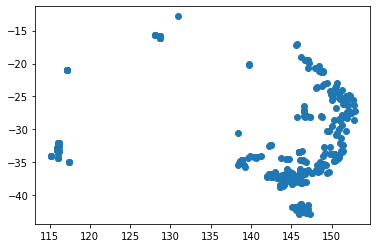

In [14]:
xs = []
ys = []
for s in station_data:
    xs.append(s[1][1])
    ys.append(s[1][0])
plt.scatter(xs, ys)

What do these look like?

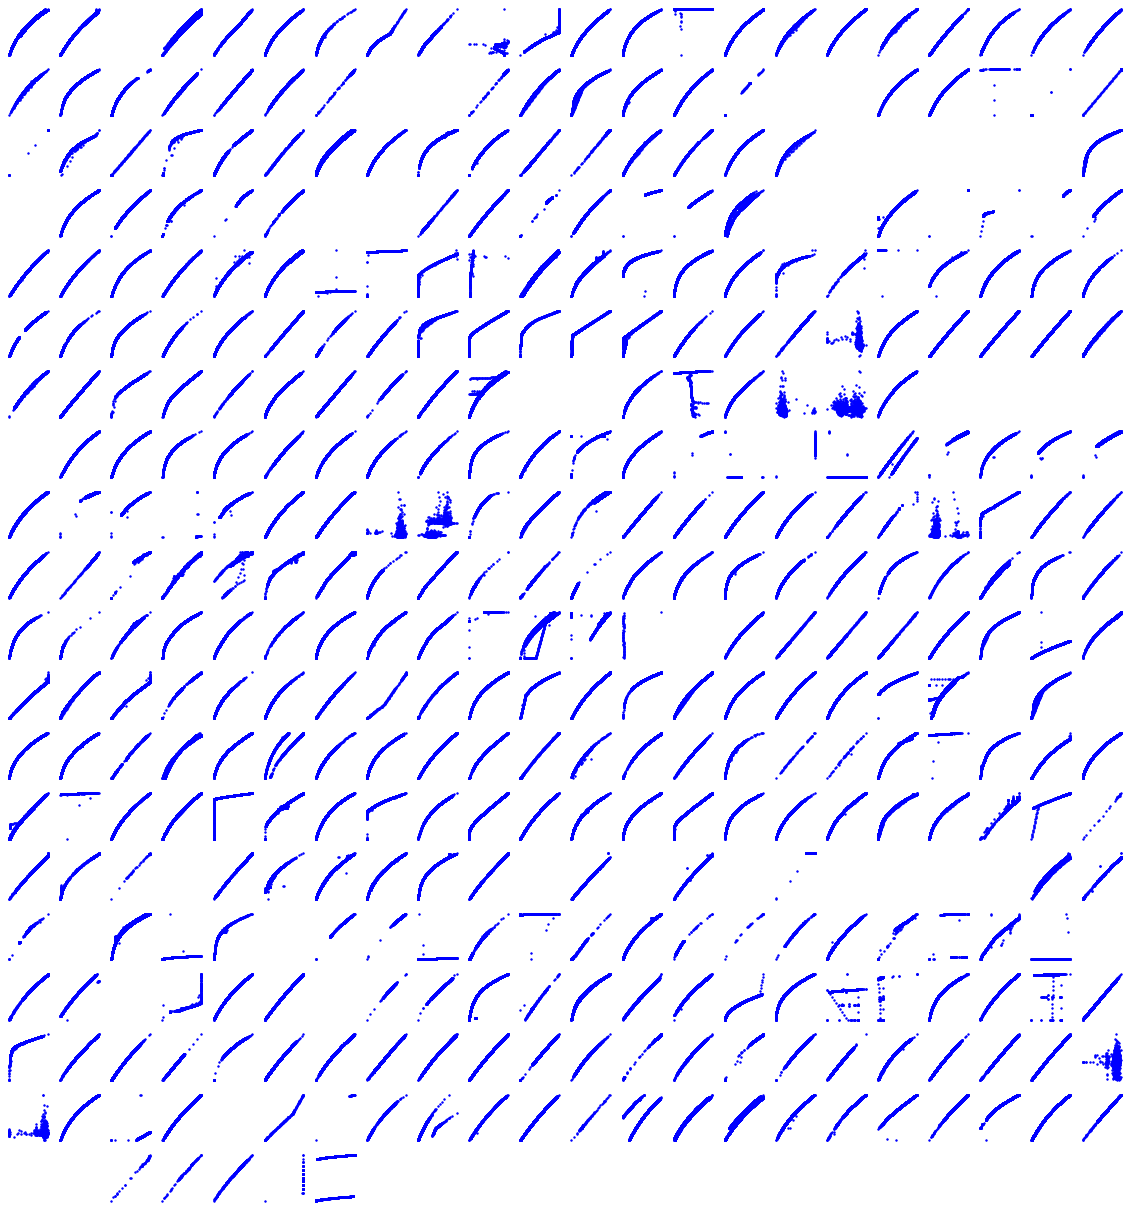

In [15]:
plt.figure(figsize=(20, 22))
for i, s in enumerate(station_data.values()):
    ax = plt.subplot(20, 22, i + 1)
#     ax.set_title(i)
    s.plot.scatter('volume', 'height', ax=ax, s=2, c='b')
    ax.axis('off')

Build some rating curves.

In [16]:
def subsequence(seq):
    # https://stackoverflow.com/a/9832414
    if not len(seq):
        return seq

    M = [None] * len(seq)    # offset by 1 (j -> j-1)
    P = [None] * len(seq)

    # Since we have at least one element in our list, we can start by 
    # knowing that the there's at least an increasing subsequence of length one:
    # the first element.
    L = 1
    M[0] = 0

    # Looping over the sequence starting from the second element
    for i in range(1, len(seq)):
        # Binary search: we want the largest j <= L
        #  such that seq[M[j]] < seq[i] (default j = 0),
        #  hence we want the lower bound at the end of the search process.
        lower = 0
        upper = L

        # Since the binary search will not look at the upper bound value,
        # we'll have to check that manually
        if seq[M[upper-1]] < seq[i]:
            j = upper

        else:
            # actual binary search loop
            while upper - lower > 1:
                mid = (upper + lower) // 2
                if seq[M[mid-1]] < seq[i]:
                    lower = mid
                else:
                    upper = mid

            j = lower    # this will also set the default value to 0

        P[i] = M[j-1]

        if j == L or seq[i] < seq[M[j]]:
            M[j] = i
            L = max(L, j+1)

    # Building the result: [seq[M[L-1]], seq[P[M[L-1]]], seq[P[P[M[L-1]]]], ...]
    result = []
    pos = M[L-1]
    for _ in range(L):
        result.append(pos)
        pos = P[pos]

    return result[::-1]    # reversing

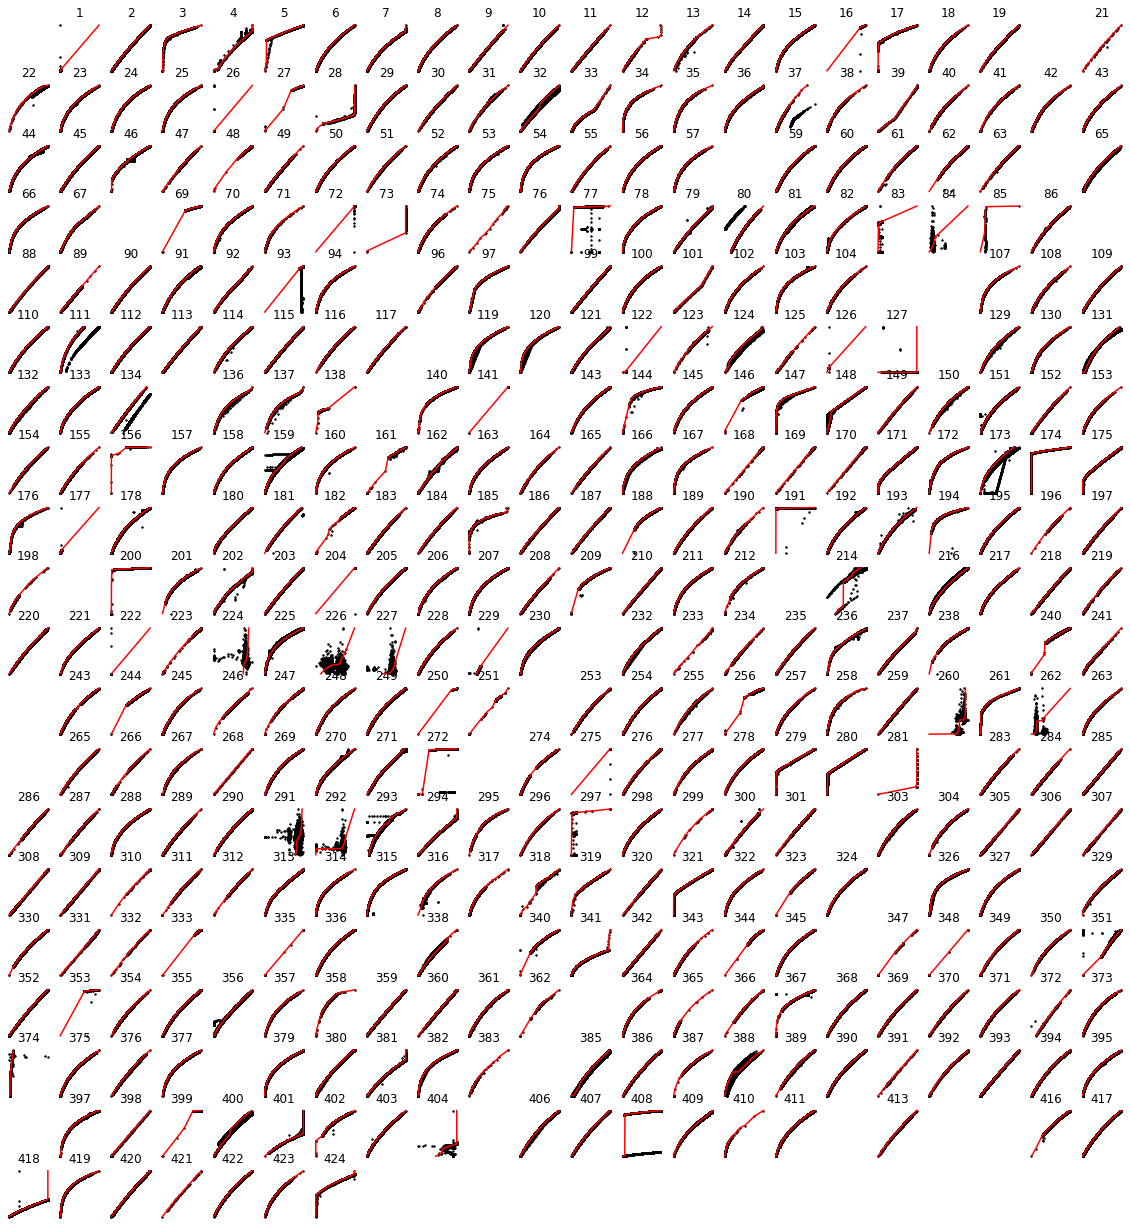

In [18]:
plt.figure(figsize=(20, 22))
h_v_models = {}
model_range = {}

for i, (n, s) in enumerate(station_data.items()):
    mask = s.volume.notnull() & s.height.notnull()
    x = s.volume[mask].values
    y = s.height[mask].values
    sortby = np.argsort(x)
    x = x[sortby]
    y = y[sortby]
    ssq = subsequence(y)
    if len(ssq) == 0:
        h_v_models[n] = None
        model_range[n] = None
        continue
    
    model = scipy.interpolate.interp1d(y[ssq], x[ssq], fill_value='extrapolate')
    model_range[n] = (min(y[ssq]), max(y[ssq]))
    h_v_models[n] = model

for i, n in enumerate(sorted(station_data)):
    ax = plt.subplot(20, 22, i + 1)
    s = station_data[n]
    s.plot.scatter('volume', 'height', ax=ax, s=2, c='k')
    ax.axis('off')
    
    if h_v_models[n] is None:
        continue

    mask = s.volume.notnull() & s.height.notnull()
    x = s.volume[mask].values
    y = s.height[mask].values
    ax.set_title(i)
    ax.plot(h_v_models[n](sorted(y)), sorted(y), c='red')

In [59]:
# bad_list_ma = [
#     0,1,4,5,12,13,16,17,21,22,26,27,28,32,33,38,47,66,71,74,75,77,79,82,83,84,85,86,87,
#     90,94,112,120,121,123,124,125,127,128,130,132,135,137,138,139,142,145,147,148,149,151,152,
#     158,161,162,163,164,175,176,178,179,180,183,184,187,191,193,194,195,196,203,204,205,207,
#     211,212,215,217,219,225,227,228,229,230,232,235,236,237,
#     239,243,247,249,253,254,258,259,263,265,273,275,278,
#     282,284,294,295,296,297,300,304,319,320,322,337,339,
#     342,344,345,351,352,355,357,360,371,377,379,386,390,393,404,405,406,407,408,409,411,413,415,421,423,426,429
# ]

# bad_list_ck = [
#     1,16,26,38,74,75,79,82,85,86,87,94,112,123,127,128,135,139,142,161,175,179,194,207,217,225,227,229,230,232,263,265,275,278,284,294,295,296,355,357,379,409,413,423
# ]

bad_list_ma_new = [
    1, 4, 16, 26, 27, 32, 37, 72, 77, 80, 83, 84, 85, 93, 111, 122, 126, 127, 134, 138, 141, 156, 159,173, 177, 191, 214, 222, 224, 226, 227,
    229, 260, 262, 272, 275, 281, 291, 292, 293, 297, 318, 333, 335, 338, 351, 353, 356, 367, 374, 388, 399, 400, 401, 404, 408, 418,
]

In [60]:
bad_stations = [n for i, n in enumerate(sorted(station_data)) if i in bad_list_ck]

Eliminate all bad stations (according to me).

In [61]:
station_data = station_data_original
station_data_original = station_data

In [62]:
station_data = {s: v for s, v in station_data.items() if s not in bad_stations}

And drop empty ones:

In [63]:
station_data = {s: v for s, v in station_data.items() if not v.volume.isnull().all() and not v.height.isnull().all() and model_range[s] is not None}

Take the interpolations and differentiate them to obtain $dV/dh = A$. Then take the longest increasing subsequence of that.

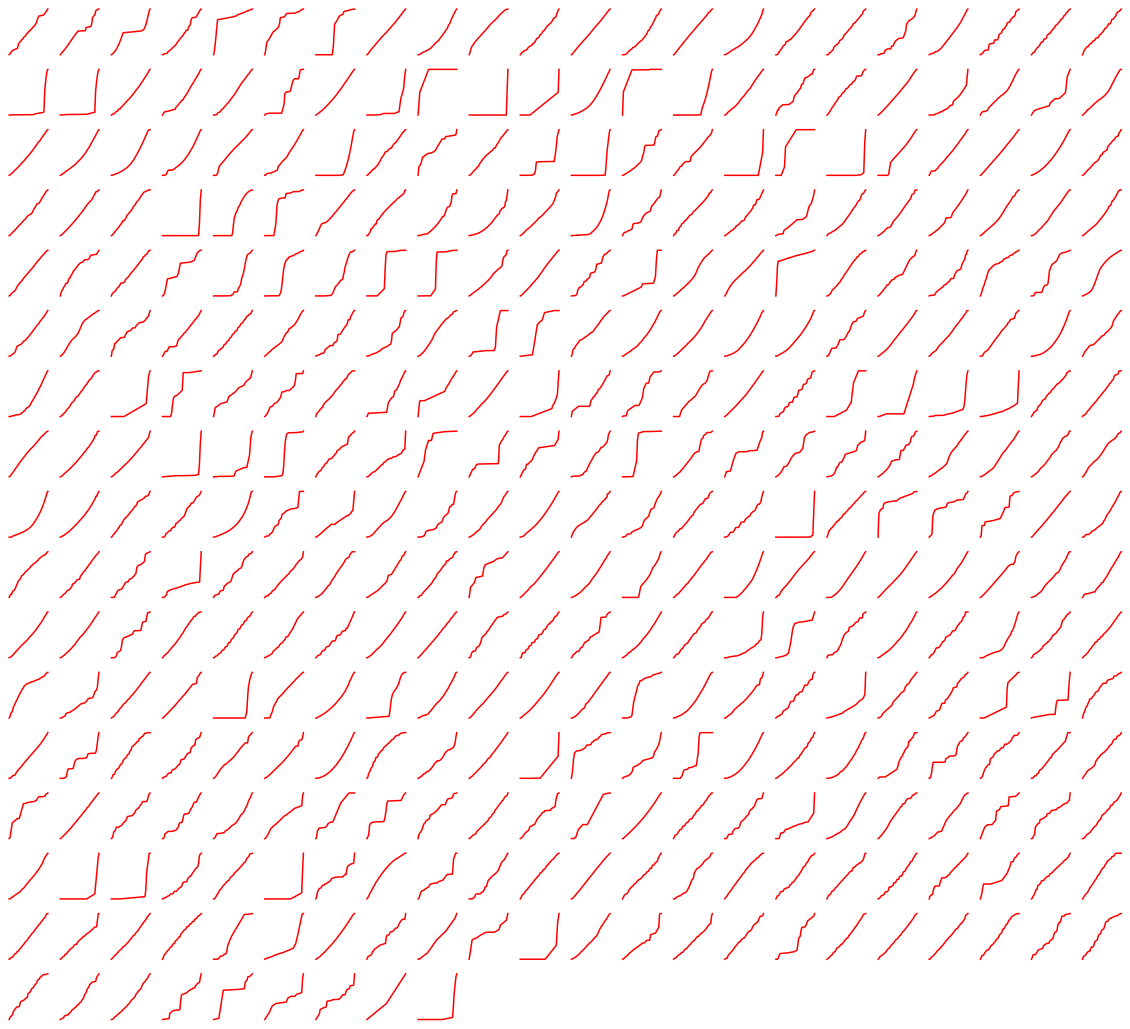

In [64]:
plt.figure(figsize=(20, 22))
h_a_models = {}
for i, (n, s) in enumerate(station_data.items()):
    ax = plt.subplot(20, 22, i + 1)
    ax.axis('off')
    if model_range[n] is None:
        continue
    c = 'red'
    xs = np.linspace(*model_range[n])
    ys = h_v_models[n](xs)
    areas = np.gradient(ys, xs)
    ssq = subsequence(areas)
    model = scipy.interpolate.interp1d(xs[ssq], areas[ssq], bounds_error=False)
    h_a_models[n] = model
    ax.plot(xs[ssq], areas[ssq], c=c)

In [65]:
len(station_data)

361

Finally, eliminate stations with less than 10 years of data.

In [114]:
station_date_range = {}
for s, d in station_data.items():
    mask = d.volume.isnull() | d.height.isnull()
    d = d[~mask]
    station_date_range[s] = d.index[-1] - d.index[0]

In [115]:
station_data = {s: v for s, v in station_data.items() if station_date_range[s] > pd.Timedelta(10 * 365, 'days')}

In [343]:
len(station_data)

190

## Load DEA Waterbodies

Now load DEA Waterbodies polygons:

In [117]:
wbs = gpd.read_file('../AusWaterBodiesFINALStateLink.shp')

Create some points to represent our gauges.

In [118]:
points = [Point(s[1][::-1]) for s in sorted(station_data)]

In [119]:
gauge_df = gpd.GeoDataFrame({'name': [s[0] for s in sorted(station_data)], 'id': [s for s in sorted(station_data)]}, geometry=points, crs='EPSG:4326')

Match them up with DEA Waterbodies within 50m.

In [207]:
joined = gpd.sjoin(wbs, gpd.GeoDataFrame(gauge_df.copy(), geometry=gauge_df.to_crs('EPSG:3577').buffer(25)), how='inner', op='intersects')

In [208]:
len(joined)

193

Remove stations without a match.

In [209]:
station_data = {s: station_data[s] for s in joined.id}

In [344]:
len(station_data)

190

There are 207 matching gauges. Let's plot the volumes against the surface areas. There should be a strictly monotonic non-decreasing relationship: as volume increases, surface area cannot decrease.

### Cross DEA Waterbodies with Geofabric reservoirs

In [210]:
geofabric = gpd.read_file('geofabric_reservoirs.geojson')

In [211]:
geofabric['geofabric_area'] = geofabric.area

In [212]:
geofabric_joined = gpd.sjoin(geofabric, wbs.set_index('UID').loc[joined.UID], op='intersects', how='inner')

In [213]:
geofabric_joined = geofabric_joined.sort_values('Shape_Area')

In [214]:
geofabric_joined = geofabric_joined[~geofabric_joined.index_right.duplicated()]

In [215]:
joined = joined[joined.UID.isin(geofabric_joined.index_right)]

In [216]:
joined[joined.name == 'Lake Argyle Dam']

,OBJECTID,Join_Count,TARGET_FID,area,perimeter,UID,FID_1,STATE,Shape_Leng,Shape_Area,timeseries,geometry,index_right,name,id
75675,75676,1,75675,307500.138346,10013.295249,qv5s37d1d,75675,WA,10000.0,307500.0,https://data.dea.ga.gov.au/projects/WaterBodie...,"POLYGON ((-351925.000 -1716225.000, -351925.00...",83,Lake Argyle Dam,"(Lake Argyle Dam, (-16.1135755, 128.732855))"


Remap Lake Argyle.

In [218]:
actual_lake_argyle = wbs.set_index('UID').loc['qv5e4j67p']
actual_lake_argyle['UID'] = 'qv5e4j67p'
for k, v in actual_lake_argyle.items():
    joined.loc[joined.name == 'Lake Argyle Dam', k] = v
    geofabric_joined.loc[geofabric_joined.index_right == 'qv5s37d1d', k] = v
geofabric_joined.loc[geofabric_joined.index_right == 'qv5s37d1d', 'index_right'] = 'qv5e4j67p'

### Download DEA Waterbodies

In [42]:
ts = {}

In [219]:
for u in tqdm(joined.UID):
    if pd.isnull(u):
        continue
    
    if u in ts:
        continue
    
    ts[u] = dea_tools.waterbodies.get_time_series(u)

  0%|          | 0/177 [00:00<?, ?it/s]

Remove the gauges with bad data according to Claire.

In [220]:
bad_list = [
    'Argyle Vill Top Dam Wsl',
    'Avon',
    'BEACONSFIELD MR WH90',
    'BITTERN RES WH100',
    'BUNDIDGERRY STORAGE',
    'Barossa Reservoir (SA Water)',
    'Buangor Storage',
    'CENTENARY RES HG',
    'Cressbrook Dam',
    'DAM-MARDI.Dam_WaterStorage_ML_BOM2012',
    'DARTMOUTH DAM',
    'Darwin R Dam I/Flow',
    'Dawson at Theodore',
    'Elmhurst Storage',
    'GOGELDRIE STORAGE',
    'Green Lake',
    'HENTY LAKE - AT DAM',
    'Harding WSL - GIS logger at Damsite',
    'Harris Wsl - Logger',
    'Hope Valley Reservoir (SA Water)',
    'INFLOW @ EASTERNSPIL',
    'INNEASTERN@LAKE BREW',
    'Island Bend Pondage',
    'Kununurra Diversion Dam Daily Water Level, North W',
    'Kununurra Dv. Water Levels SCADA',
    'Kununurra Dv. Wsl',
    'LEXTON RES. H.G.',
    'Lake Argyle Water level Logged on SCADA',
    'Lake Batyo Catyo',
    'Lake Lonsdale',
    'MALPAS DAM',
    'MAUDE STORAGE',
    'MURCHISON LAKE - AT DAM',
    'MUSICAL GULLY RES.',
    'Moora Moora Reservoir',
    'Moura Off-stream',
    'Mt Cole Reservoir',
    'Mundaring Water levels - SCADA',
    'NAMOI@MOLLEE WR STOR',
    'New Victoria WSL - Logger Data',
    'No 7 Dam',
    'OUTEASTERN@LAKE BREW',
    'PIEMAN LAKE [AT DAM]',
    'Perseverance Dam',
    'Pine Lake',
    'R Murray us Lock 3',
    'R Murray us Lock 4',
    'R Murray us Lock 5',
    'REDBANK STORAGE',
    'REPULSE LAKE - AT DAM',
    'SOUTH@LAKE BREWSTER',
    'STONY C TABLOT RES.',
    'Serp. P/Head Water Level - Logger',
    'Serpentine Main Dam WSL - Logger',
    'Stirling Dam Storage Level',
    'Swampy-Khancbn Pond',
    'Tallowa',
    'Taylors Lake',
    'Toolondo Reservoir',
    'Val Bird HW',
    'Woongarra OS',
]

bad_list += [j.id[0] for i, j in joined.iterrows() if 'weir' in j.id[0].lower()]

In [221]:
joined = joined[~joined.id.apply(lambda a: a[0]).isin(bad_list)]

In [335]:
r2s = {}
r2s_list = []
max_areas_list = []
spearman_list = []
spearmans = {}
is_tas_list = []

wbs_si = wbs.set_index('UID')
for i, j in tqdm(enumerate(joined.itertuples()), total=len(joined)):
    sa = ts[j.UID]
    h = station_data[j.id].height
    sa_bom = pd.Series(h_a_models[j.id](h), index=h.index)
    sa = sa[~sa.index.duplicated()]
    sa = sa.tz_convert(0).resample('1D').mean()
    sa_bom = sa_bom.tz_convert(0).resample('1D').mean()
    xs = sa_bom.reindex(sa.index) * 1000
    ys = sa.px_wet * 25 ** 2
    ok = pd.notnull(xs) & pd.notnull(ys)
    r2 = scipy.stats.linregress(xs[ok], ys[ok]).rvalue ** 2
    sp = scipy.stats.spearmanr(xs[ok], ys[ok])
    spearman_list.append(sp.correlation)
    r2s[j.id] = r2
    r2s_list.append(r2)
    shape = wbs_si.loc[j.UID]
    max_areas_list.append(shape.area)
    spearmans[j.id] = sp
    is_tas_list.append(j.STATE == 'TAS')

  0%|          | 0/139 [00:00<?, ?it/s]

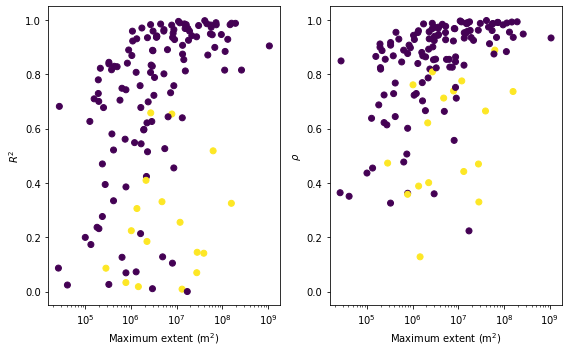

In [338]:
plt.figure(figsize=(8, 5))
gs = plt.GridSpec(1, 2)
pad = 0.05

ax = plt.subplot(gs[0, 0])
ax.scatter(max_areas_list, r2s_list, c=is_tas_list)
ax.set_xscale('log')
ax.set_ylabel('$R^2$')
ax.set_ylim(-pad, 1 + pad)
ax.set_xlabel('Maximum extent (m$^2$)')
ax = plt.subplot(gs[0, 1])
ax.scatter(max_areas_list, spearman_list, c=is_tas_list)
ax.set_ylim(-pad, 1 + pad)
ax.set_xscale('log')
ax.set_ylabel('$\\rho$')
ax.set_xlabel('Maximum extent (m$^2$)')
plt.tight_layout()

In [346]:
len(r2s_list)

139

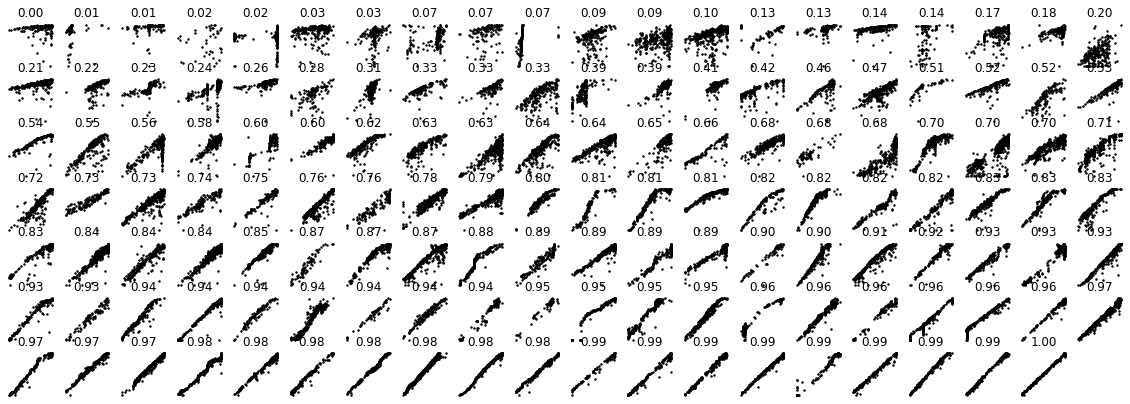

In [224]:
plt.figure(figsize=(20, 22))
for i, j in enumerate(np.argsort(np.nan_to_num(r2s_list))):
    j = joined.iloc[j]
    ax = plt.subplot(22, 20, i + 1)
    ax.axis('off')
    
    # grey out waterbodies < 20 px²
    gt = j.area / 25 ** 2 > 20
    if gt:
        c = 'k'
    else:
        c = 'lightgrey'

    # otherwise plot volume against surface area
    sa = ts[j.UID]
    h = station_data[j.id].height
    sa_bom = pd.Series(h_a_models[j.id](h), index=h.index)
    sa = sa[~sa.index.duplicated()]
    sa = sa.tz_convert(0).resample('1D').mean()
    sa_bom = sa_bom.tz_convert(0).resample('1D').mean()
    xs = sa_bom.reindex(sa.index) * 1000
    ys = sa.px_wet * 25 ** 2
    ok = pd.notnull(xs) & pd.notnull(ys)
    r2 = scipy.stats.linregress(xs[ok], ys[ok]).rvalue ** 2
    ax.scatter(xs, ys, s=2, c=c)
    ax.set_title(f'{r2:.2f}')
    ax.axis('off')

In [243]:
straya = gpd.read_file('../../dea-notebooks/enso/straya/ne_10m_admin_0_countries.shp').set_index('ADMIN').loc[['Australia']]

Text(-90, -20, 'St. Clair Lake')

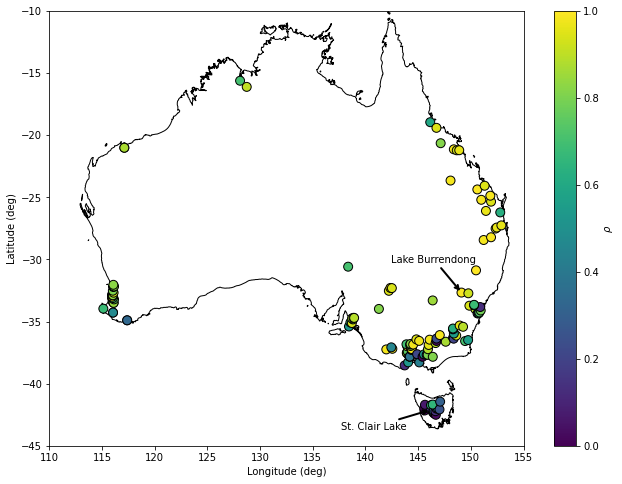

In [330]:
plt.figure(figsize=(11, 8))
xs = []
ys = []
rs = []
for s, r in r2s.items():
    ys.append(s[1][0])
    xs.append(s[1][1])
    rs.append(r)
plt.scatter(xs, ys, c=rs, zorder=10, vmin=0, vmax=1, s=80, ec='k', linewidth=1)
plt.colorbar(label='$\\rho$')
plt.gca().set_aspect('equal')
straya.plot(ax=plt.gca(), ec='k', fc='None')
plt.ylim(-45, -10)
plt.xlim(110, 155)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')

bloc = joined.set_index('name').loc['BURRENDONG DAM'].id[1][::-1]
sloc = joined.set_index('name').loc['St.CLAIR LAKE - AT PUMP HOUSE POINT'].id[1][::-1]
plt.annotate('Lake Burrendong', bloc, xytext=(-70, 30), textcoords='offset points', zorder=12,
            arrowprops=dict(arrowstyle='->', lw=2))
plt.annotate('St. Clair Lake', (sloc[0], sloc[1]), xytext=(-90, -20), textcoords='offset points', zorder=12,
            arrowprops=dict(arrowstyle='->', lw=2, ec='k'))

Plot the distribution of R² and ρ.

Text(0, 0.5, 'Number of waterbodies/gauges')

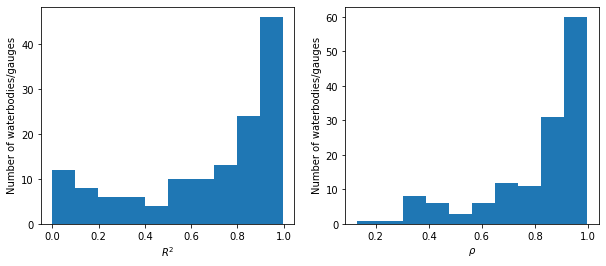

In [263]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(r2s_list)
axs[1].hist(spearman_list)
axs[0].set_xlabel('$R^2$')
axs[1].set_xlabel('$\\rho$')
axs[0].set_ylabel('Number of waterbodies/gauges')
axs[1].set_ylabel(axs[0].get_ylabel())

Text(0, 0.5, 'Number of waterbodies/gauges')

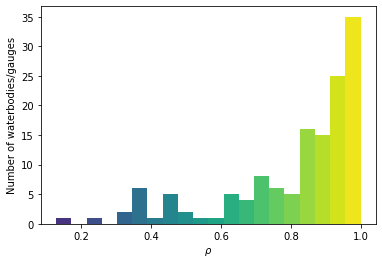

In [341]:
fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(spearman_list, bins=20)
bin_centres = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(plt.cm.viridis(bin_centres), patches):
    plt.setp(p, 'facecolor', c)
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Number of waterbodies/gauges')

In [342]:
len(spearman_list)

139

Print this as a table.

In [228]:
r2_table = []
for n, r2 in r2s.items():
    r2_table.append([n[0], spearmans[n].correlation])

In [229]:
pd.DataFrame(r2_table, columns=['gauge', 'ρ']).sort_values('gauge')[:10]

,gauge,ρ
83,ARTHURS LAKE - AT PUMP STATION,0.889079
109,Aroona Creek/Dam,0.845471
130,Atkinson Head Water,0.976751
104,Avon Dam,0.556786
101,BROGO DAM,0.506475
78,BRONTE LAGOON - AT DAM,0.712523
28,BURBURY LAKE - AT CROTTY DAM,0.442255
117,BURRENDONG DAM,0.991438
60,Barkers Creek Storage,0.954638
122,Boondooma Dam,0.986096


In [358]:
min({s:v for s, v in spearmans.items() if joined.set_index('name').loc[s[0]].STATE != 'TAS'}, key=spearmans.get)

('Talbingo Res - RO', (-35.62396389, 148.29991667))

Now let's measure the mean absolute deviation.

In [231]:
station_ordering = np.argsort(joined.id)

In [232]:
mads = []
mads_dates = []
for i, j in enumerate(station_ordering):
    j = joined.iloc[j]
    if 'weir' in j.id[0].lower():
        print('skipping', j.id[0])
        continue
    sa = ts[j.UID]
    h = station_data[j.id].height
    sa_bom = pd.Series(h_a_models[j.id](h), index=h.index)
    sa = sa[~sa.index.duplicated()]
    sa = sa.tz_convert(0).resample('1D').mean()
    sa_bom = sa_bom.tz_convert(0).resample('1D').mean()
    xs = sa_bom.reindex(sa.index) * 1000
    ys = sa.px_wet * 25 ** 2
    # Convert to percentage of maximum extent
    bom_area = geofabric_joined.set_index('index_right').loc[j.UID].geofabric_area
    dea_area = geofabric_joined.set_index('index_right').loc[j.UID].Shape_Area
    xs = xs / bom_area * 100
    ys = ys / bom_area * 100
    mads.extend(xs - ys)
    mads_dates.extend(xs.index)

/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [233]:
mads_df = pd.DataFrame({'diff': mads}, index=pd.to_datetime(mads_dates))
mads_df['year'] = mads_df.index.year
mads_df['month'] = mads_df.index.month

In [234]:
mads_year = mads_df.groupby('year').apply(lambda df: np.nanmedian(abs(df['diff'])))
mads_month = mads_df.groupby('month').apply(lambda df: np.nanmedian(np.clip(abs(df['diff']), 0, 100)))

/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Text(0, 0.5, 'Mean absolute deviation')

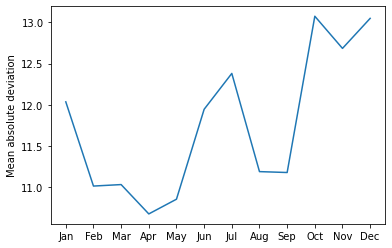

In [235]:
import calendar
plt.plot(calendar.month_abbr[1:], mads_month)
plt.ylabel('Mean absolute deviation')

Text(0, 0.5, 'Median absolute deviation')

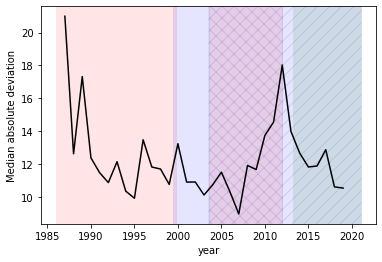

In [236]:
mads_year.plot(c='k')
plt.axvspan(1986, 1999 + 11 / 12, fc='red', alpha=0.1)
plt.axvspan(2003 + 7 / 12, 2011 + 11 / 12, fc='red', alpha=0.1, hatch='\\\\', ec='darkblue')
plt.axvspan(1999 + 5 / 12, 2003 + 6 / 12, fc='blue', alpha=0.1)
plt.axvspan(2003 + 6 / 12, 2021, fc='blue', alpha=0.1, hatch='//', ec='darkblue')
plt.axvspan(2013 + 3 / 12, 2021, fc='green', alpha=0.1)
plt.ylabel('Median absolute deviation')

/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


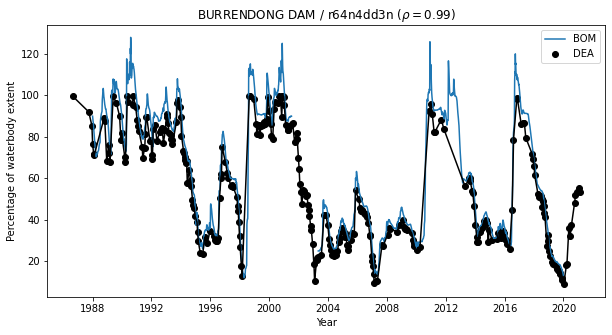

<Figure size 720x360 with 0 Axes>

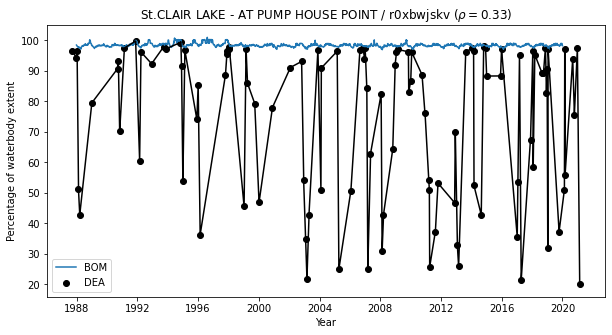

/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


<Figure size 720x360 with 0 Axes>

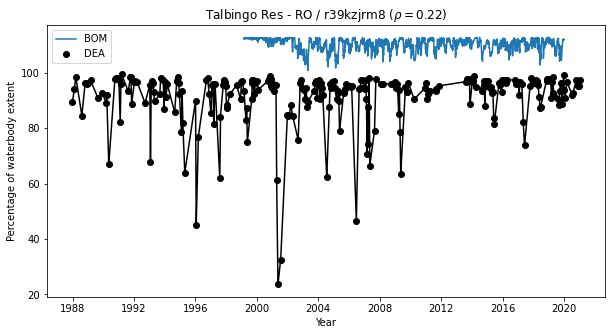

<Figure size 720x360 with 0 Axes>

In [359]:
import calendar
mads = []
for i, j in enumerate(station_ordering):
    j = joined.iloc[j]
    if 'weir' in j.id[0].lower():
        print('skipping', j.id[0])
        continue
    if 'BURRENDONG' not in j.id[0] and 'CLAIR' not in j.id[0] and 'Talbingo Res - RO' not in j.id[0]:
        continue
    sa = ts[j.UID]
    h = station_data[j.id].height
    sa_bom = pd.Series(h_a_models[j.id](h), index=h.index)
    sa = sa[~sa.index.duplicated()]
    sa = sa.tz_convert(0).resample('1D').mean()
    sa_bom = sa_bom.tz_convert(0).resample('1D').mean()
    xs = sa_bom.reindex(sa.index) * 1000
    ys = sa.px_wet * 25 ** 2
    # Convert to percentage of maximum extent
    bom_area = geofabric_joined.set_index('index_right').loc[j.UID].geofabric_area
#     bom_area = np.nanpercentile(xs.values, 98)
    dea_area = geofabric_joined.set_index('index_right').loc[j.UID].Shape_Area
    xs = xs / dea_area * 100
    ys = ys / dea_area * 100
    plt.figure(figsize=(10, 5))
    plt.plot(sa.index, xs, c='C0', label='BOM')
    plt.scatter(sa.index, ys, label='DEA', marker='o', c='k')
    plt.plot(sa.index, ys.interpolate(), c='k')
    plt.ylabel('Percentage of waterbody extent')
    plt.xlabel('Year')
    plt.legend()
    plt.title(f'{j.id[0]} / {j.UID} ($\\rho = {spearmans[j.id].correlation:.2f}$)')
#     plt.ylim(-5, 105)
    plt.show()
    plt.figure(figsize=(10, 5))
#     diff = pd.DataFrame({'diff': xs - ys}, index=(xs - ys).index)
#     diff['month'] = diff.index.month
#     month_agg = diff.groupby('month').mean()
#     plt.plot(calendar.month_abbr[1:], month_agg['diff'], label='BOM - DEA')
#     plt.scatter(sa.index, ys, label='DEA', marker='o', c='k')
#     plt.plot(sa.index, (xs - ys).interpolate(), c='k')
#     plt.ylabel('BOM - DEA residual')
#     plt.xlabel('Year')
#     plt.legend()
#     plt.title(f'{j.id[0]} / {j.UID} ($R^2 = {r2s[j.id]:.2f}$)')
#     plt.ylim(-105, 105)
#     plt.show()
    mads.extend(xs - ys)

/env/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/env/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


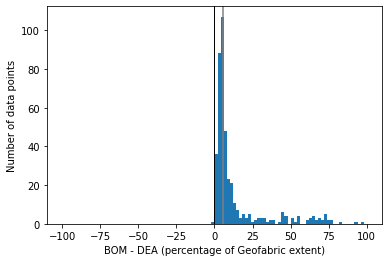

In [352]:
plt.hist(mads, bins=100, range=(-100, 100));
plt.xlabel('BOM - DEA (percentage of Geofabric extent)')
plt.ylabel('Number of data points')
plt.axvline(0, c='k', linewidth=1)
plt.axvline(np.nanmedian(mads), c='grey')

In [149]:
np.nanmean(np.clip(mads, -100, 100))

10.516331155404554